## 프로젝트 요약
1. 프로젝트 : Data Labeling
2. 프로젝트 : Feature Engineering
3. 프로젝트 : Model Traning

## __1. 프로젝트 : Data Labeling__
위에서 배운 Data Labeling 4가지를 직접 적용해봅시다.  

① __Price Change Direction__ 적용하기  
② __Using Moving Average__ 적용하기  
③ __Local Min-Max__ 적용하기  
④ __Trend Scanning__ 적용하기  

In [1]:
# 필요한 라이브러리 및 패키지 확인 후 실행
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

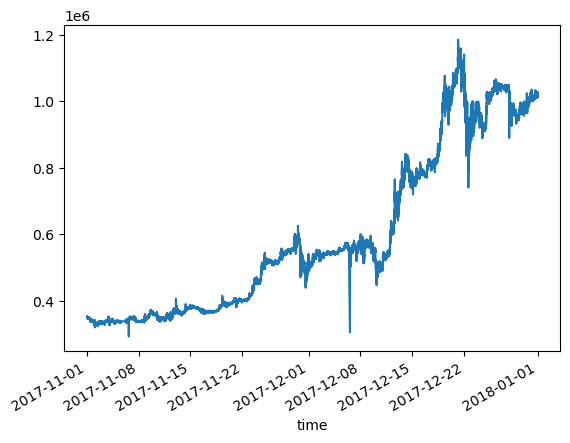

In [3]:
# 데이터 불러오기
modify_data = pd.read_csv(('sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

### __① Price Change Direction 적용하기__  
아래의 수식을 적용하여 momentum_signal을 만들어봅시다. 그리고 기존의 데이터(modify_data)와 수식이 적용된 데이터(momentum_signal)를 시각화하여 어떤 차이가 있는지 비교해봅시다.
$$i(t) = \begin{cases} 1, & \text{if } \text{price}_t - \text{price}_{t-n} > 0 \\0, & \text{otherwise}\end{cases}$$  
먼저 window를 설정합니다. 보통 window는 시계열 데이터에서 이전 시점과 현재 시점간의 간격을 구간별로 잘라서 사용하곤 합니다. 이렇게 사용하는 이유는 정확한 예측을 달성하기 위해 우리가 가지고 있는 정보를 과거로부터 주어진 시점에서 가능한 안전하게 보존된 정보를 모델에 제공하기 위해 Window로 다시 구성한 다음 모델에 input으로 주입하는 것입니다. window는 보통 time series data 외에도 많이 사용하는 기법입니다.(ex. 정렬 알고리즘, CNN의 sliding 등...)
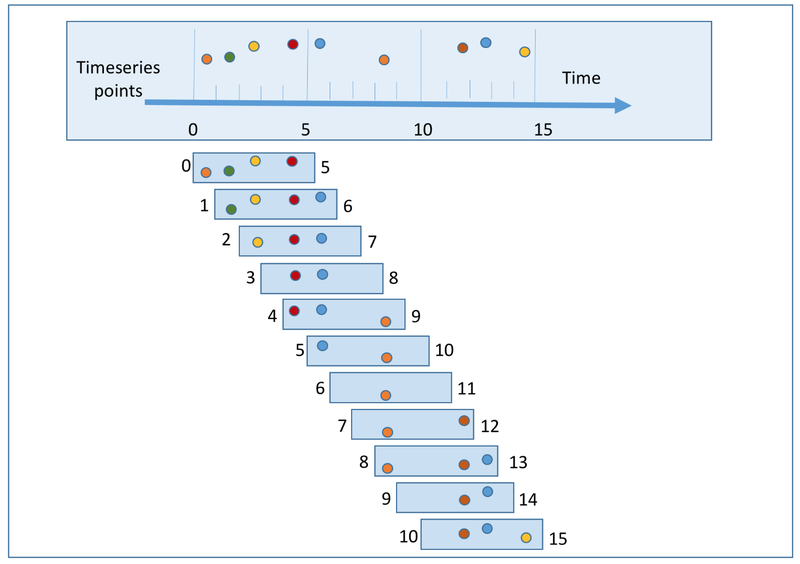
[https://docs.wavefront.com/query_language_windows_trends.html]


In [5]:
# Q. 코드를 작성해주세요

# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index = modify_data.index) # 데이터 활용을 위해 pd.Series를 사용합니다.

기존의 데이터(modify_data)에서 필요한 close(종가)를 가져오고 수식이 적용된 데이터(s_momentum_signal)의 종가와 얼마나 차이가 있는지 확인하기 위해 데이터를 변환하고 시각화합니다.

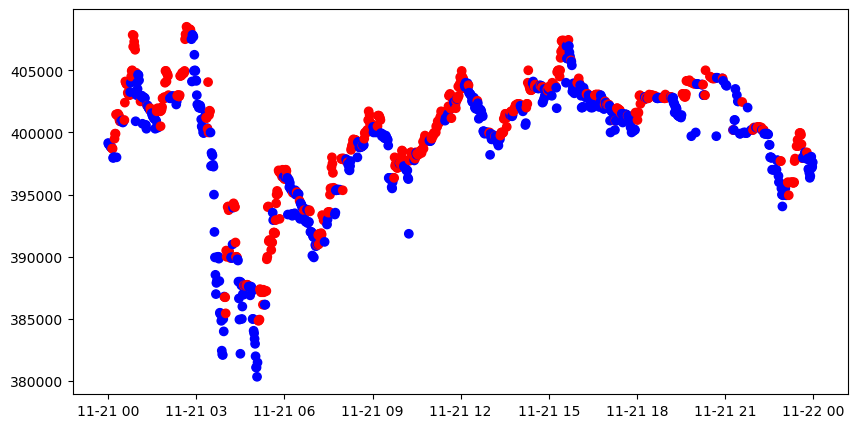

In [6]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # np.where 사용

# 시각화하기
plt.figure(figsize = (10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### __② Using Moving Average 적용하기__  
앞서 사용했던 이동평균선을 이용한 방식을 적용해봅시다. 수식은 아래과 같습니다.
$$i(t) = \begin{cases} 1, & \text{if price}_t > \text{MA}(t \ldots t-n) \\0, & \text{otherwise}\end{cases}$$

In [7]:
# Q. 코드를 작성해주세요

# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index = modify_data.index) # pd.Series로 변환

앞서 "① Price Change Direction 적용하기"에서 진행했던 것처럼 시각화를 위해 Using Moving Average 수식을 적용한 것과 비교하기 위해 데이터를 변환하여 시각화를 통해 확인합니다.

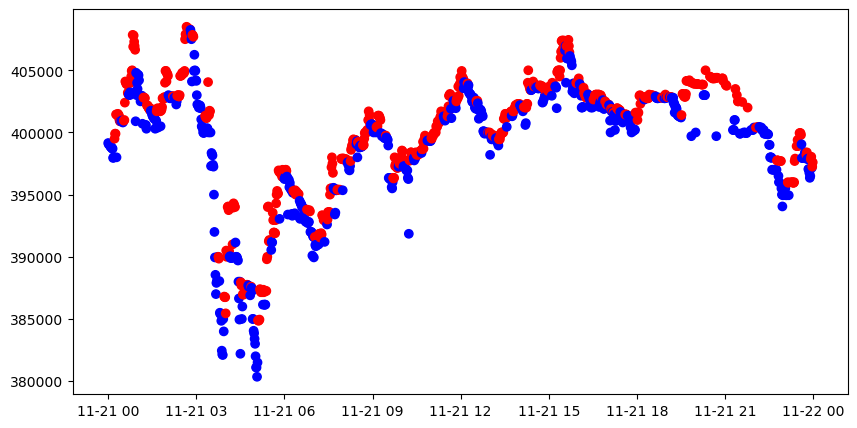

In [8]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize = (10, 5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### __③ Local Min-Max 적용하기__  
최소 - 최대 구간을 이어나가며 Labeling하는 함수를 아래 수도코드(pseudo-code)를 보고 만들어봅시다.

𝐼𝑛𝑖𝑡𝑖𝑎𝑙𝑖𝑧𝑒 𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠𝑓𝑜𝑟 𝑖 𝑖𝑛 𝑑𝑎𝑡𝑎𝑠𝑒𝑡:  
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒<𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒  
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒  
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑  
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒  
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒>𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒  
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒  
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑  
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒  
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑  
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒  
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑  
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒  

①~⑦까지 코드를 자세히 들여다보고 어떠한 방식으로 코드가 동작되는지 뜯어봅시다.  
⑧ return 값은 dictionary 형태로 2개의 DataFrame이 반환되어야합니다.

In [10]:
# Q. 코드를 작성해주세요

# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # ⑤
            # [[YOUR CODE]] # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) # ⑧

get_local_min_max 함수를 사용하면 return 값이 2개가 나오게 됩니다. 아래 주석을 제거하여 min과 maxes의 값이 어떻게 나오는지 확인해봅시다.

In [11]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

              min_time  local_min
0  2017-11-21 00:01:00     399050
1  2017-11-21 00:03:00     399000
2  2017-11-21 00:04:00     398900
3  2017-11-21 00:05:00     398850
4  2017-11-21 00:06:00     398800
5  2017-11-21 00:08:00     398700
6  2017-11-21 00:10:00     397950
7  2017-11-21 03:30:00     397300
8  2017-11-21 03:35:00     397250
9  2017-11-21 03:36:00     395000
10 2017-11-21 03:37:00     392000
11 2017-11-21 03:38:00     389950
12 2017-11-21 03:39:00     388550
13 2017-11-21 03:40:00     387000
14 2017-11-21 03:48:00     385500
15 2017-11-21 03:49:00     385400
16 2017-11-21 03:51:00     384850
17 2017-11-21 03:52:00     382450
18 2017-11-21 03:53:00     382150
19 2017-11-21 03:54:00     382100
20 2017-11-21 05:01:00     382000
21 2017-11-21 05:02:00     381100
22 2017-11-21 05:04:00     380350
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3  

(376546.5, 412585.0)

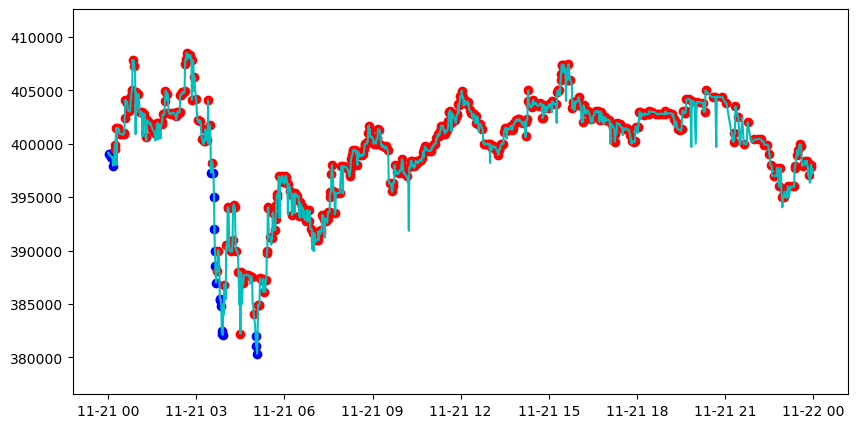

In [12]:
# Q. 코드를 작성해주세요

# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c = 'blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c = 'red')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

### __④ Trend Scanning 적용하기__
Trend Scanning을 구현해봅시다.
$$x_{t+l} = \beta_0 + \beta_1 * l + \epsilon_{t+l}$$
$$\hat{\beta}_1 = \frac{\sigma}{\sqrt{\beta_1}}$$
$$i(t) = \begin{cases}1, & \text{if } \max(\hat{\beta}_1) > 0 \\0, & \text{otherwise}\end{cases}$$

OLS는 회귀분석을 하는 경우 유용하게 사용할 수 있으며 아래 함수에서 ols.tvalue를 통해 t-value값을 사용할 수 있는 함수를 활용하여 추세(trend)를 추정합니다.

In [13]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [14]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [15]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [23:12<00:00, 23.97it/s]  


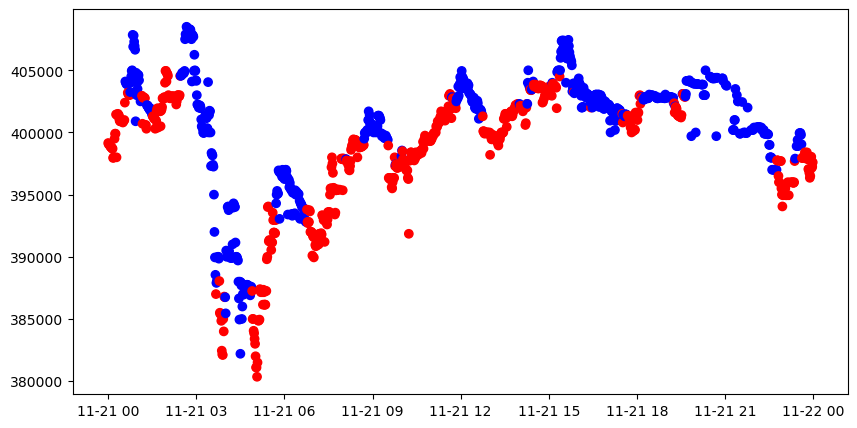

In [16]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

## __2. 프로젝트 : Feature Engineering__
① 환경구성 및 데이터 불러오기  
② Technical Index 적용하기  
③ Feature Selection methods 적용하기

### __① 환경구성 및 데이터 불러오기__  
환경구성 및 데이터를 불러옵니다.

In [17]:
# !pip install ta==0.9.0
# !pip install shap

In [18]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [19]:
# 데이터 경로 설정
DATA_PATH = '.'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

#### __② Technical Index 적용하기__  
앞서 배운 기술적 지표와 수익률/변동성 지표를 참고하여 코드를 뜯어봅시다.

In [20]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [21]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [22]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [23]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight = 'balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

#### __③ Feature Selection methods 적용하기__
__MDI, Mean Decrease Impurity__

In [24]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.052361,0.002210
volume_fi,0.040508,0.002109
volume_mfi,0.043597,0.002221
volume_sma_em,0.037573,0.001714
volume_vpt,0.025902,0.001801
volatility_atr,0.077540,0.003587
volatility_ui,0.045796,0.002137
trend_macd_diff,0.078336,0.003298
trend_adx,0.054259,0.002381
trend_trix,0.064867,0.002613


__MDA, Mean Decrease Accuracy__

In [25]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [26]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

plot_feature_importance 함수를 사용하여 feat_imp와 feat_imp_mda를 확인해봅시다.

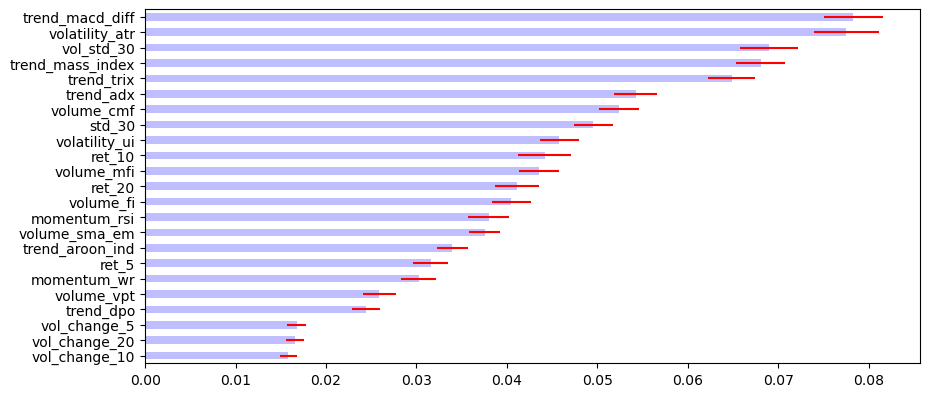

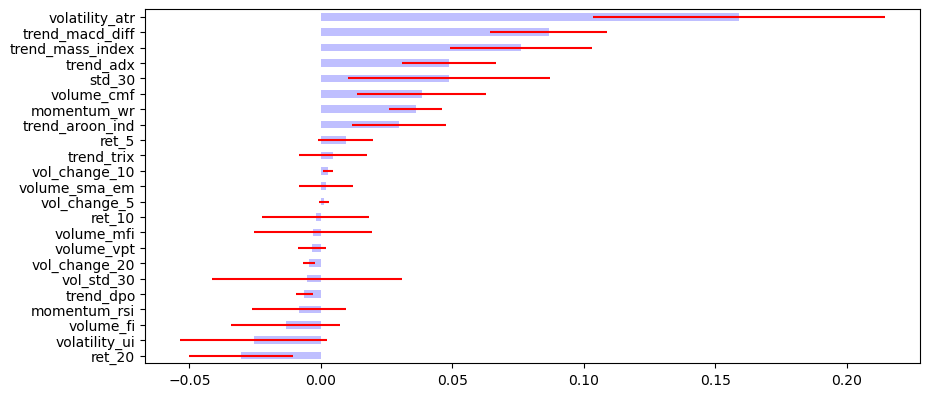

In [27]:
# Q. 코드를 작성해주세요

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

__RFE CV, Recursive Feature Eliminationm__

In [28]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV 사용
rfe_fitted = rfe_cv.fit(X_sc, y) # fit 사용

__SFS, Sequential Feature Selection__

In [29]:
# SFS, Sequential Feature Selection
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

__SHAP, Shapley Additive explanations__

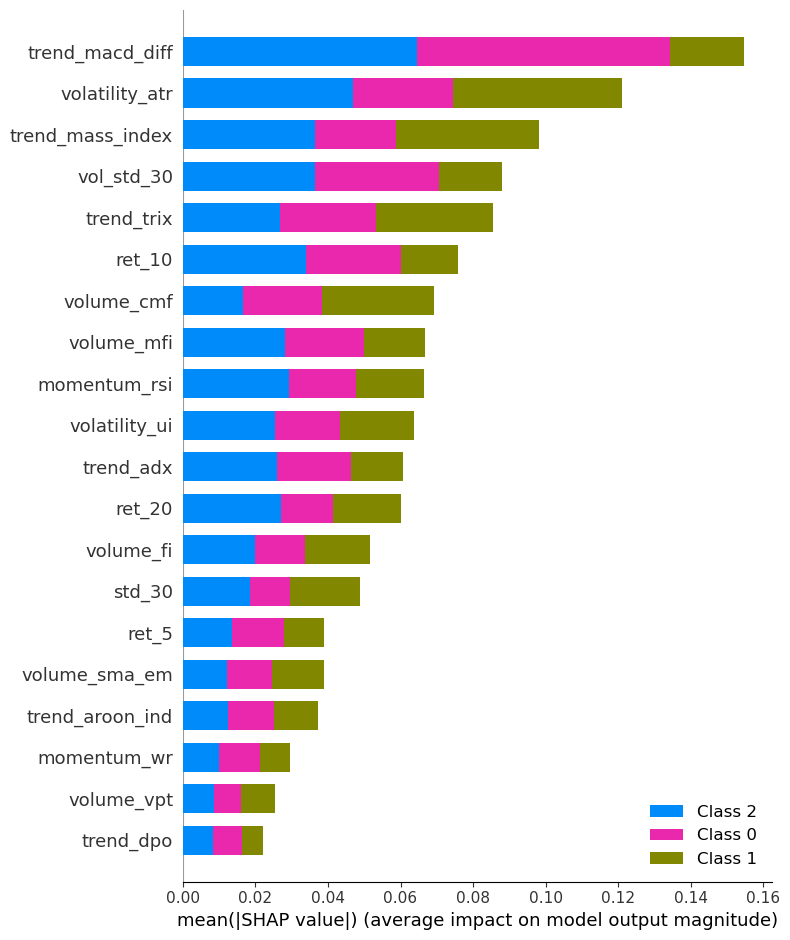

In [30]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

## __3. 프로젝트 : Model Traning__  
① 환경구성 및 데이터 불러오기  
② Purged K-fold for Cross-Validation적용하기  
③ Model 적용하기

### __① 환경구성 및 데이터 불러오기__

In [31]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('.')
from libs.mlutil.pkfold import PKFold

In [35]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '.'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

### __② Purged K-fold for Cross-Validation적용하기__

In [36]:
# Q. 코드를 작성해주세요

n_cv = 5 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

### __③ Model 적용하기__

In [37]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [38]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [39]:
# Q. 코드를 작성해주세요

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [40]:
# Q. 코드를 작성해주세요

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv = cv, n_jobs = -1, verbose = 1)

In [42]:
# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   max_features='auto',
                                                   min_samples_leaf=5),
                  max_features=0.7, n_estimators=5)

In [43]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [44]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[84 52]
 [13 42]]
정확도:0.6596858638743456, 정밀도:0.44680851063829785, 재현율:0.7636363636363637


auc:0.6906417112299466


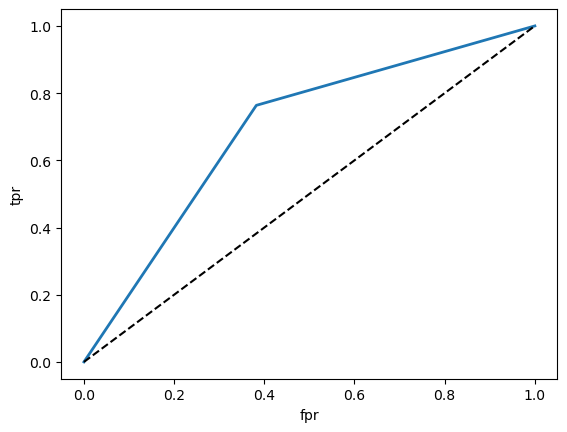

In [45]:
# Q. 코드를 작성해주세요

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

## 회고  
제가...뭘 하고 있는거죠?